<a href="https://colab.research.google.com/github/drewamorbordelon/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/LS_DS20_432_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/train/mountain/art1131.jpg?raw=1)|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/validation/forest/cdmc317.jpg?raw=1)|

The problem is relatively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several different possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pre-trained layers from resnet
4. Report your model's accuracy

In [1]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model # This is the functional API

from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D

resnet = ResNet50(weights='imagenet', include_top=False)

In [2]:
for layer in resnet.layers:
    layer.trainable = False

In [3]:
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

In [4]:
# resnet.summary()

In [5]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Load in Data

This surprisingly more difficult than it seems, because you are working with directories of images instead of a single file. This boiler plate will help you download a zipped version of the directory of images. The directory is organized into "train" and "validation" which you can use inside an `ImageGenerator` class to stream batches of images thru your model.  


### Download & Summarize the Data

This step is completed for you. Just run the cells and review the results. 

In [6]:
import tensorflow as tf
import os

_URL = 'https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data.zip?raw=true'

path_to_zip = tf.keras.utils.get_file('./data.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [8]:
train_mountain_dir = os.path.join(train_dir, 'mountain')  # directory with our training cat pictures
train_forest_dir = os.path.join(train_dir, 'forest')  # directory with our training dog pictures
validation_mountain_dir = os.path.join(validation_dir, 'mountain')  # directory with our validation cat pictures
validation_forest_dir = os.path.join(validation_dir, 'forest')  # directory with our validation dog pictures

In [9]:
num_mountain_tr = len(os.listdir(train_mountain_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountain_val = len(os.listdir(validation_mountain_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

total_train = num_mountain_tr + num_forest_tr
total_val = num_mountain_val + num_forest_val

In [10]:
print('total training mountain images:', num_mountain_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountain images:', num_mountain_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountain images: 254
total training forest images: 270
total validation mountain images: 125
total validation forest images: 62
--
Total training images: 524
Total validation images: 187


### Keras `ImageGenerator` to Process the Data

This step is completed for you, but please review the code. The `ImageGenerator` class reads in batches of data from a directory and pass them to the model one batch at a time. Just like large text files, this method is advantageous, because it stifles the need to load a bunch of images into memory. 

Check out the documentation for this class method: [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class). You'll expand it's use in the third assignment objective.

In [11]:
batch_size = 16
epochs = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 533 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 195 images belonging to 2 classes.


In [15]:
images, labels = next(train_data_gen)

In [16]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
  fig, axes = plt.subplots(4,4, figsize=(10,10)) #four rows by 4 columns
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

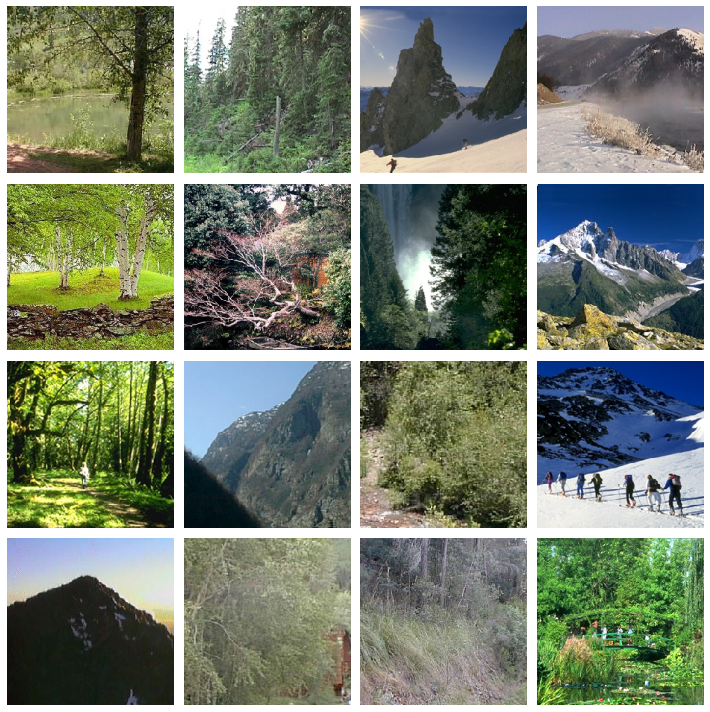

[0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]


In [17]:
plotImages(images)
print(labels)

## Instatiate Model

In [18]:
import tensorflow_hub as hub

# Create model

resnet = ResNet50(weights='imagenet', include_top=False)

x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)



for layer in resnet.layers:
    layer.trainable = False

model = Model(resnet.input, predictions)


model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'] )


## Fit Model

In [19]:
result = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/10
32/32 [==============================] - 4s 110ms/step - loss: 0.8654 - accuracy: 0.5529 - val_loss: 0.5989 - val_accuracy: 0.7273
Epoch 2/10
32/32 [==============================] - 3s 80ms/step - loss: 0.5949 - accuracy: 0.6846 - val_loss: 0.6072 - val_accuracy: 0.7443
Epoch 3/10
32/32 [==============================] - 3s 79ms/step - loss: 0.5370 - accuracy: 0.7365 - val_loss: 0.5462 - val_accuracy: 0.7557
Epoch 4/10
32/32 [==============================] - 3s 81ms/step - loss: 0.4642 - accuracy: 0.8125 - val_loss: 0.4185 - val_accuracy: 0.8523
Epoch 5/10
32/32 [==============================] - 3s 81ms/step - loss: 0.4225 - accuracy: 0.8379 - val_loss: 0.4366 - val_accuracy: 0.8466
Epoch 6/10
32/32 [==============================] - 3s 81ms/step - loss: 0.3848 - accuracy: 0.8683 - val_loss: 0.3613 - val_accuracy: 0.8523
Epoch 7/10
32/32 [==============================] - 3s 80ms/step - loss: 0.3631 - accuracy: 0.8703 - val_loss: 0.4148 - val_accuracy: 0.8295
Epoch 8/10
3

# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [20]:
# Define the Model
n_windows = 224 #weight matrix
window_size = (3,3)# how large the window is to look at
act_funct = 'relu'
image_dim = (224, 224, 3)

modelC = Sequential()
modelC.add(Conv2D(n_windows, window_size, activation='relu', input_shape=(224,224,3)))
modelC.add(MaxPooling2D((2,2)))
modelC.add(Conv2D(32, (3,3), activation='relu'))
modelC.add(MaxPooling2D((2,2)))
modelC.add(Conv2D(32, (3,3), activation='relu'))
modelC.add(Flatten())
modelC.add(Dense(32, activation='relu'))
modelC.add(Dense(2, activation='softmax'))

modelC.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 224)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      64544     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

In [21]:
# Compile Model
modelC.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Fit Model
resultC = modelC.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/10
32/32 [==============================] - 3s 96ms/step - loss: 0.8309 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.3409
Epoch 2/10
32/32 [==============================] - 3s 84ms/step - loss: 0.6932 - accuracy: 0.5190 - val_loss: 0.6932 - val_accuracy: 0.3523
Epoch 3/10
32/32 [==============================] - 3s 84ms/step - loss: 0.6932 - accuracy: 0.5170 - val_loss: 0.6932 - val_accuracy: 0.3466
Epoch 4/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6932 - accuracy: 0.5176 - val_loss: 0.6931 - val_accuracy: 0.3182
Epoch 5/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6931 - accuracy: 0.5210 - val_loss: 0.6931 - val_accuracy: 0.3466
Epoch 6/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6931 - val_accuracy: 0.3580
Epoch 7/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6931 - accuracy: 0.5190 - val_loss: 0.6931 - val_accuracy: 0.3068
Epoch 8/10
32

# Custom CNN Model with Image Manipulations

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Simply, you should be able to modify our image generator for the problem. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
_URL = 'https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data.zip?raw=true'

path_to_zip2 = tf.keras.utils.get_file('./data.zip', origin=_URL, extract=True)
PATH2 = os.path.join(os.path.dirname(path_to_zip), 'data')

In [25]:
batch_size = 16
epochs = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [26]:
train_dir2 = os.path.join(PATH, 'train')
validation_dir2 = os.path.join(PATH, 'validation')

In [27]:
train_image_gen2 = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
#     featurewise_std_normalization=True,
#                 rotation_range=20,
#                 width_shift_range=0.2,
#                 height_shift_range=0.2,
#                 horizontal_flip=True
                                    
# batch_size = 100
# batch_gen = image_gen.flow(images, labels, batch_size=batch_size, )

In [28]:
val_image_gen2 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

                                  

In [29]:
train_data_gen2 = train_image_gen2.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 533 images belonging to 2 classes.


In [30]:
val_data_gen2 = val_image_gen2.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 195 images belonging to 2 classes.


In [31]:
images, labels = next(train_data_gen2)

In [32]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
  fig, axes = plt.subplots(4,4, figsize=(10,10)) #four rows by 4 columns
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

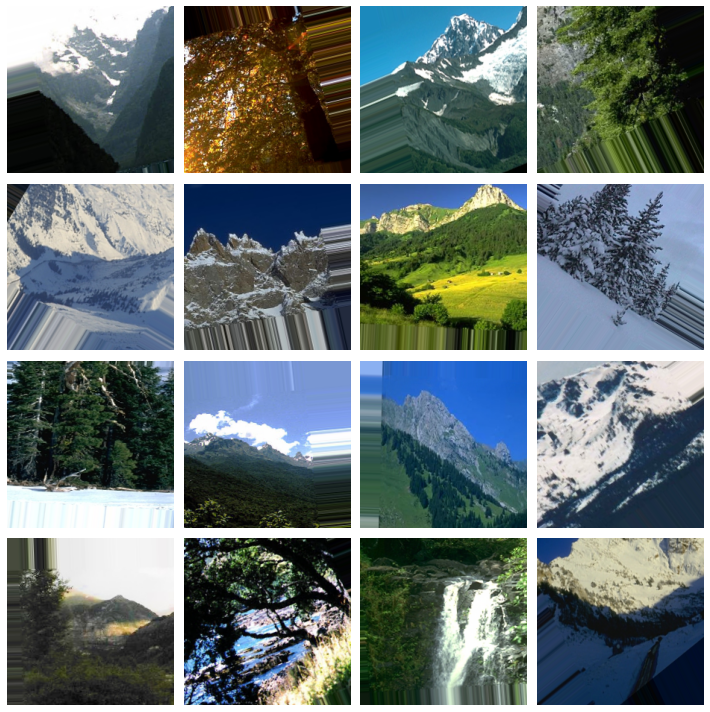

[1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.]


In [33]:
plotImages(images)
print(labels)

In [34]:
n_windows = 224 #weight matrix
window_size = (3,3)# how large the window is to look at
act_funct = 'relu'
image_dim = (224, 224, 3)

modelMC = Sequential()
modelMC.add(Conv2D(n_windows, window_size, activation='relu', input_shape=(224,224,3)))
modelMC.add(MaxPooling2D((2,2)))
modelMC.add(Conv2D(32, (3,3), activation='relu'))
modelMC.add(MaxPooling2D((2,2)))
modelMC.add(Conv2D(32, (3,3), activation='relu'))
modelMC.add(Flatten())
modelMC.add(Dense(32, activation='relu'))
modelMC.add(Dense(1, activation='sigmoid'))

modelMC.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 224)     6272      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      64544     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [35]:
modelMC.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:

resultMC = modelMC.fit(
    train_data_gen2,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen2,
    validation_steps=total_val // batch_size
)

Epoch 1/10
32/32 [==============================] - 9s 287ms/step - loss: 0.6827 - accuracy: 0.6327 - val_loss: 1.3287 - val_accuracy: 0.4375
Epoch 2/10
32/32 [==============================] - 9s 282ms/step - loss: 0.4385 - accuracy: 0.8303 - val_loss: 0.2673 - val_accuracy: 0.8977
Epoch 3/10
32/32 [==============================] - 9s 282ms/step - loss: 0.2647 - accuracy: 0.9042 - val_loss: 0.2101 - val_accuracy: 0.9091
Epoch 4/10
32/32 [==============================] - 9s 283ms/step - loss: 0.3028 - accuracy: 0.8867 - val_loss: 0.2612 - val_accuracy: 0.9034
Epoch 5/10
32/32 [==============================] - 9s 283ms/step - loss: 0.2805 - accuracy: 0.8762 - val_loss: 0.3638 - val_accuracy: 0.8409
Epoch 6/10
32/32 [==============================] - 9s 284ms/step - loss: 0.2693 - accuracy: 0.8822 - val_loss: 0.3320 - val_accuracy: 0.8523
Epoch 7/10
32/32 [==============================] - 9s 285ms/step - loss: 0.2561 - accuracy: 0.8982 - val_loss: 0.3671 - val_accuracy: 0.8580
Epoch 

In [37]:
modelMC.save_weights('resultMC')

       loss  accuracy  val_loss  val_accuracy  epoch
0  0.682676  0.632735  1.328712      0.437500      0
1  0.438464  0.830339  0.267307      0.897727      1
2  0.264699  0.904192  0.210068      0.909091      2
3  0.302811  0.886719  0.261171      0.903409      3
4  0.280468  0.876248  0.363815      0.840909      4


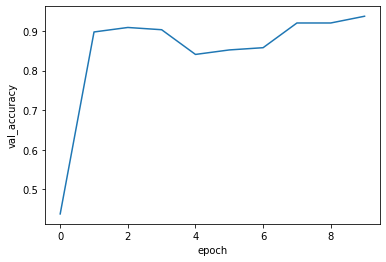

In [38]:
import pandas as pd
import seaborn as sns
# Visualize accuracy and epochs
resultMC_df= pd.DataFrame(resultMC.history)
resultMC_df['epoch']= resultMC_df.index.values
print(resultMC_df.head())
sns.lineplot(x = 'epoch', y = 'val_accuracy' , data = resultMC_df);

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language